# Attach trial wise parameters to idata

HSSM automatically cleans up the idata object we return from samplers, to avoid unnecessarily huge objects from being passed around (the decision was taken after having observed many inadvertent *out of memory* errors).

Instead, if so desired, we can attach the trial wise parameters to the idata object ourselves, using the `add_likelihood_parameters_to_idata` function.

This quick tutorial shows you how to do this.

### Load Modules

In [ ]:
import pandas as pd

import hssm

### Simulate Data

In [ ]:
# Condition 1
condition_1 = hssm.simulate_data(
    model="ddm", theta=dict(v=0.5, a=1.5, z=0.5, t=0.1), size=500
)

# Condition 2
condition_2 = hssm.simulate_data(
    model="ddm", theta=dict(v=1.0, a=1.5, z=0.5, t=0.1), size=500
)

condition_1["condition"] = "C1"
condition_2["condition"] = "C2"

data = pd.concat([condition_1, condition_2]).reset_index(drop=True)

### Define Model and Sample

In [ ]:
model = hssm.HSSM(
    model="ddm",
    data=data,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + condition",
        }
    ],
)

idata = model.sample(sampler="mcmc", tune=500, draws=500)

Model initialized successfully.
Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, t, z, v_Intercept, v_condition]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
100%|██████████| 2000/2000 [00:00<00:00, 2757.59it/s]


### Checking the `idata` object

In [ ]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Note that none of the parameters attached in the posterior have the observation coordinate (`__obs__`). However, looking at the model graph, we clearly see that for variables that are represented as regression targets, we in fact compute intermediate deterministics which do have dimensionality `__obs__`.

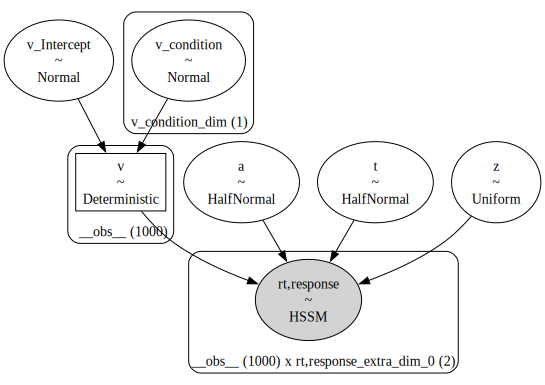

In [ ]:
model.graph()

### Computing Trial Wise Parameters

We can use the `compute_likelihood_parameters_to_idata` function to recompute and include in our `idata` the trial wise deterministics, which are part of our model graph.

In [ ]:
### Attach Trial Wise Parameters
idata_trialwise = model.add_likelihood_parameters_to_idata(idata)

### Checking the `idata` object
idata_trialwise

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Note how the idata include the `v` parameter which has the `__obs__` coordinate. Computing these trial-wise parameters, can
serve us well for plotting and other post-hoc analyses, here we would otherwise struggle to be effective without incurring some pre-computation pain (which in addition would be error prone). See e.g. the tutorial on **hierarchical Variational Inference** for an example.